# When will the UK Population be Fully Vaccinated Against Covid-19?



In [1]:
from requests import get
from json import dumps

import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc('figure', figsize=[12, 10])
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize)
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
figsize_21 = (width, 2*height)
%matplotlib inline

## Getting the data

In [2]:
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"
AREA_TYPE = "overview"

filters = [
    f"areaType={ AREA_TYPE }",
]
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}
api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))
}
response = get(ENDPOINT, params=api_params, timeout=10)

if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')


In [3]:
j = response.json()
print(j.keys())

dict_keys(['length', 'maxPageLimit', 'data', 'pagination'])


In [4]:
print(j["length"], j["maxPageLimit"])

78 2500


In [5]:
print(j["data"][0])

{'date': '2021-03-28', 'newFirst': 293542, 'cumFirst': 30444829, 'newSecond': 146785, 'cumSecond': 3674266}


In [6]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
df.index.name = ""
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
,,,,
2021-03-24,0.337665,28.991188,0.242642,2.775481
2021-03-25,0.324942,29.316130,0.234382,3.009863
2021-03-26,0.411305,29.727435,0.283654,3.293517
2021-03-27,0.423852,30.151287,0.233964,3.527481
2021-03-28,0.293542,30.444829,0.146785,3.674266


## Vaccines so far

In [7]:
# no. people getting vaccinations (in millions)
# https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf
priority_totals = {
    "Groups 1-4": 15,
    "Groups 1-9": 32,
    "All Adults": 53
}


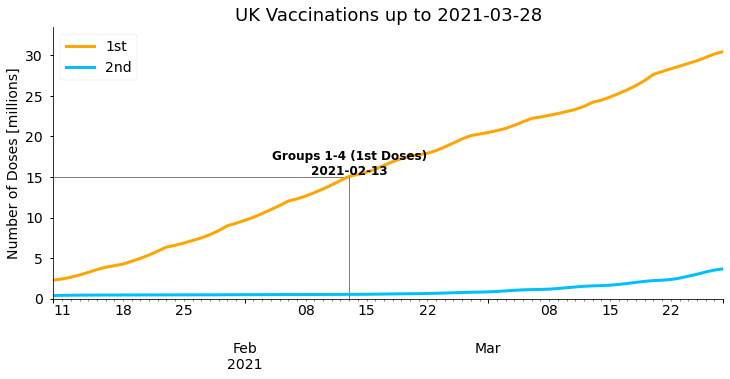

In [8]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    max_y = df["cumFirst"].max() * 1.1  # y-axis limit
    ax.set_ylim([0, max_y])
    text_offset = 1.02
    columns = ["cumFirst", "cumSecond"]
    labels = ["1st", "2nd"]
    colors = ["orange", "deepskyblue"]

    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab in zip(columns, colors, labels):
        # plot actual data with a solid line
        df[col][
            df[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=lab, linewidth=3)

        # plot forecast data with a dashed line
        if plot_forecast:
            df[col][
                df[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"{lab} (Forecast)")

        # label priority group completion dates
        max_col = df[col].max()
        for name, pop in priority_totals.items():
            if max_col >= pop:  # vaccines completed for this group
                complete_date = df[df[col] >= pop].iloc[0].name

                ax.hlines(pop, 0, complete_date , color="k",linewidth=0.5)
                ax.axvline(complete_date, ymax=pop/max_y, color="k",linewidth=0.5)
                ax.text(
                    complete_date,
                    pop*text_offset,
                    f"{name} ({lab} Doses)\n{complete_date.date()}",
                    ha="center",
                    size=12,
                    fontweight="bold",
                )
            
    ax.legend()
    ax.set_ylabel("Number of Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_cumulative_doses(
    df, title=f"UK Vaccinations up to {df.index.date.max()}"
)

In [9]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]


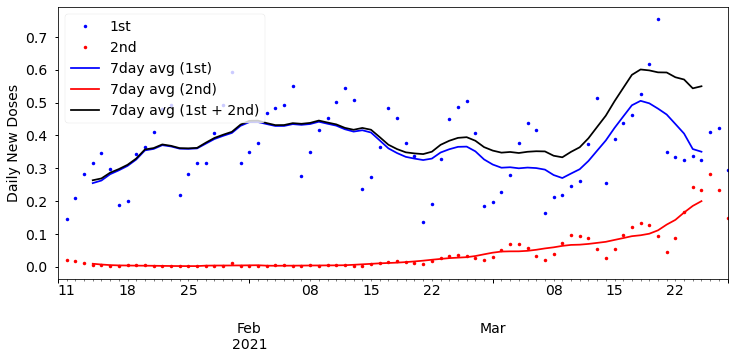

In [10]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

df["newFirst"].plot(color="b", linestyle="None", marker=".", label="1st", ax=ax)
df["newSecond"].plot(color="r", linestyle="None", marker=".", label="2nd", ax=ax)

n_avg = 7
df.rolling(window=n_avg, center=True).mean()["newFirst"].plot(color="b", label="7day avg (1st)", ax=ax)
df.rolling(window=n_avg, center=True).mean()["newSecond"].plot(color="r", label="7day avg (2nd)", ax=ax)
df.rolling(window=n_avg, center=True).mean()["newTot"].plot(color="k", label="7day avg (1st + 2nd)", ax=ax)

ax.set_ylabel("Daily New Doses")
ax.legend()



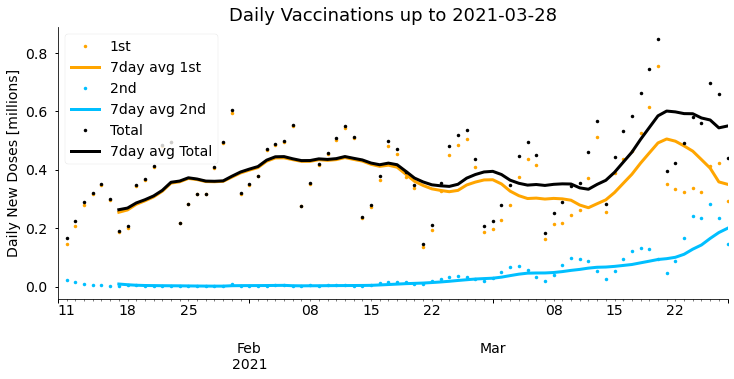

In [11]:
def plot_daily_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot daily first and second doses, the sum of 1st and 2nd doses,
    and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    columns = ["newFirst", "newSecond", "newTot"]
    labels = ["1st", "2nd", "Total"]
    colors = ["orange", "deepskyblue", "k"]
    show_daily = [True, True, True]

    n_avg = 7
    roll_avg = df.rolling(window=n_avg).mean()


    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab, daily in zip(columns, colors, labels, show_daily):
        if daily:
            df[col].plot(color=clr, linestyle="None", marker=".", label=lab, ax=ax)

        # plot actual rolling average data with a solid line
        roll_avg[col][
            roll_avg[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=f"7day avg {lab}", linewidth=3)

        # plot forecast rolling average data with a dashed line
        if plot_forecast:
            roll_avg[col][
                roll_avg[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"7day avg {lab} (Forecast)")
            
    ax.legend()
    ax.set_ylabel("Daily New Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_daily_doses(
    df, title=f"Daily Vaccinations up to {df.index.date.max()}"
)

<AxesSubplot:xlabel='newTot', ylabel='Count'>

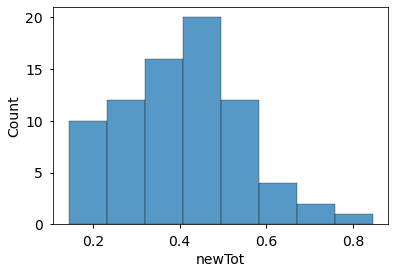

In [12]:
sns.histplot(x="newTot", data=df)

Text(0, 0.5, 'Daily Doses (1st + 2nd)')

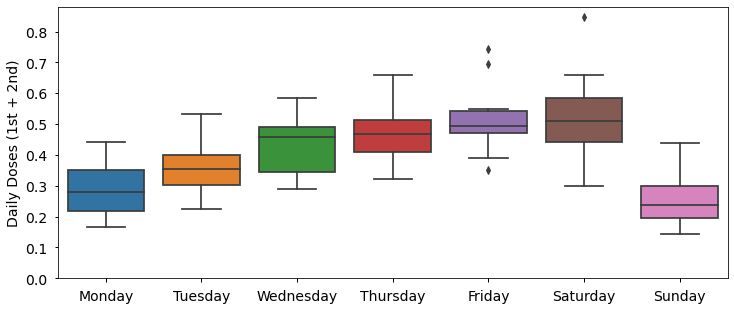

In [13]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday", y="newTot", data=df,
    order=[
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday",
        "Sunday"
    ]
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd)")

## When are 2nd doses being given?

In [14]:
df["cumSecond"].max()

3.674266

In [15]:
df["cumFirst"].min()

2.289831

In [16]:
df[df["cumSecond"] >= df["cumFirst"].min()]

,newFirst,cumFirst,newSecond,cumSecond,newTot,cumTot,weekday
,,,,,,,
2021-03-22,0.335001,28.329582,0.087542,2.365327,0.422543,30.694909,Monday
2021-03-23,0.323941,28.653523,0.167512,2.532839,0.491453,31.186362,Tuesday
2021-03-24,0.337665,28.991188,0.242642,2.775481,0.580307,31.766669,Wednesday
2021-03-25,0.324942,29.316130,0.234382,3.009863,0.559324,32.325993,Thursday
2021-03-26,0.411305,29.727435,0.283654,3.293517,0.694959,33.020952,Friday
2021-03-27,0.423852,30.151287,0.233964,3.527481,0.657816,33.678768,Saturday
2021-03-28,0.293542,30.444829,0.146785,3.674266,0.440327,34.119095,Sunday


71 days 00:00:00


<AxesSubplot:>

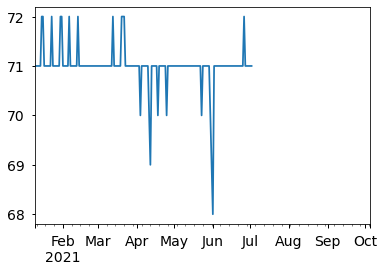

In [28]:
print(datetime(2021, 3, 22) - df.index.min())

for date_1st, row in df.iterrows():
    if row["cumFirst"] > df["cumSecond"].max():
        break
    elif row["cumSecond"] >= df["cumFirst"].max():
        break
    elif row["cumFirst"] == df["cumFirst"].max():
        break
    
    date_2nd = df[df["cumSecond"] >= row["cumFirst"]].index.min()
    
    delay = (date_2nd - date_1st).days
    df.loc[date_1st, "delaySecond"] = delay
    
df["delaySecond"].plot()

In [18]:
df

,newFirst,cumFirst,newSecond,cumSecond,newTot,cumTot,weekday,delaySecond
,,,,,,,,
2021-01-10,NaN,2.289831,NaN,0.390555,NaN,2.680386,Sunday,71.0
2021-01-11,0.145690,2.435521,0.021159,0.411714,0.166849,2.847235,Monday,71.0
2021-01-12,0.207988,2.643509,0.016065,0.427779,0.224053,3.071288,Tuesday,71.0
2021-01-13,0.280735,2.924244,0.009745,0.437524,0.290480,3.361768,Wednesday,71.0
2021-01-14,0.315809,3.240053,0.005257,0.442781,0.321066,3.682834,Thursday,71.0
...,...,...,...,...,...,...,...,...
2021-03-24,0.337665,28.991188,0.242642,2.775481,0.580307,31.766669,Wednesday,NaN
2021-03-25,0.324942,29.316130,0.234382,3.009863,0.559324,32.325993,Thursday,NaN
2021-03-26,0.411305,29.727435,0.283654,3.293517,0.694959,33.020952,Friday,NaN


In [19]:
# days after 1st dose that 2nd dose given
# 3 to 12 weeks: https://www.gov.uk/government/publications/covid-19-vaccination-what-to-expect-after-vaccination/what-to-expect-after-your-covid-19-vaccination#what-to-do-next
second_dose_days = 71


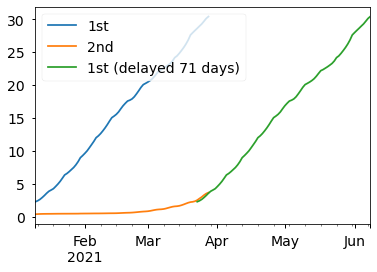

In [20]:
delayed_1st = df["cumFirst"].copy()
delayed_1st.index = delayed_1st.index + timedelta(days=72)
df["cumFirst"].plot(label="1st")
df["cumSecond"].plot(label="2nd")
delayed_1st.plot(label="1st (delayed 71 days)")
plt.legend()

## Forecasting Future Vaccinations

In [21]:
# date daily vaccination data avaliable from
first_data = datetime(2021, 1, 10)

# date to forecast until
end_date = datetime(2021, 10, 5)

# calculate average across this many days and forecast no.
# doses given today to be the same as this many days ago
n_avg = 7


uk_pop = priority_totals["All Adults"]



In [22]:
last_data = df.index.max()
df = df.append(pd.DataFrame(index=pd.date_range(last_data, end_date, closed="right")))
df.sort_index(inplace=True)

In [23]:

future_dates = pd.date_range(start=last_data + timedelta(days=1), end=end_date)
for d in future_dates:
    if d - timedelta(days=second_dose_days) < first_data:
        pending_2nd_doses = 0
    else:
        # no. second doses needed today is difference between total
        # 2nd doses so far and 1st doses second_dose_days ago (who
        # now require 2nd dose)
        dose2_req = df.loc[
            d - timedelta(days=second_dose_days), "cumFirst"
        ]
        dose2_sofar =  df.loc[
            d - timedelta(days=1), "cumSecond"
        ]
        pending_2nd_doses = max([0, dose2_req - dose2_sofar])

    # forecast to give same doses today as n_avg days ago
    total_doses_today = df.loc[d - timedelta(days=n_avg), "newTot"]
    if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
        total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]
    df.loc[d, "newTot"] = total_doses_today
    
    dose2_today = min(pending_2nd_doses, total_doses_today)
    df.loc[d, "newSecond"] = dose2_today
    df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + df.loc[d, "newSecond"]

    dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
    dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
    df.loc[d, "newFirst"] = dose1_today
    df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + df.loc[d, "newFirst"]

    df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]


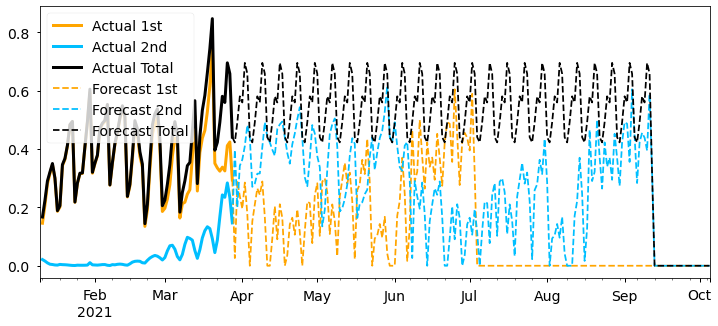

In [24]:
plt.figure(figsize=figsize)

rollFirst = df["newFirst"]  #.rolling(window=n_avg).mean()
rollSecond = df["newSecond"]  #.rolling(window=n_avg).mean()
rollTotal = df["newTot"]  #.rolling(window=n_avg).mean()

rollFirst[rollFirst.index <= last_data].plot(color="orange", label="Actual 1st", linewidth=3)
rollSecond[rollSecond.index <= last_data].plot(color="deepskyblue", label="Actual 2nd", linewidth=3)
rollTotal[rollTotal.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)

rollFirst[rollFirst.index >= last_data].plot(color="orange", linestyle="--", label="Forecast 1st")
rollSecond[rollSecond.index >= last_data].plot(color="deepskyblue", linestyle="--", label="Forecast 2nd")
rollTotal[rollTotal.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")


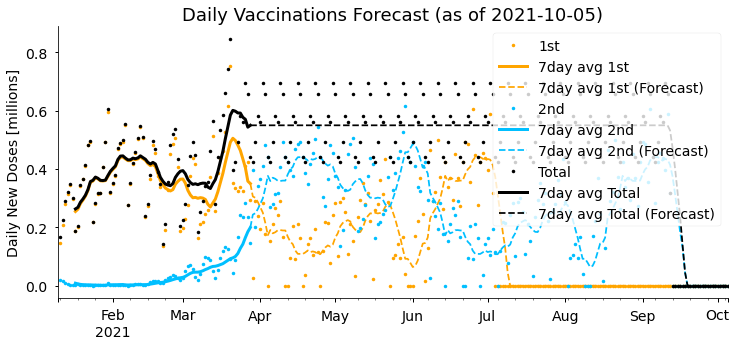

In [25]:
plot_daily_doses(
    df, forecast_date=last_data,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})"
)

<AxesSubplot:>

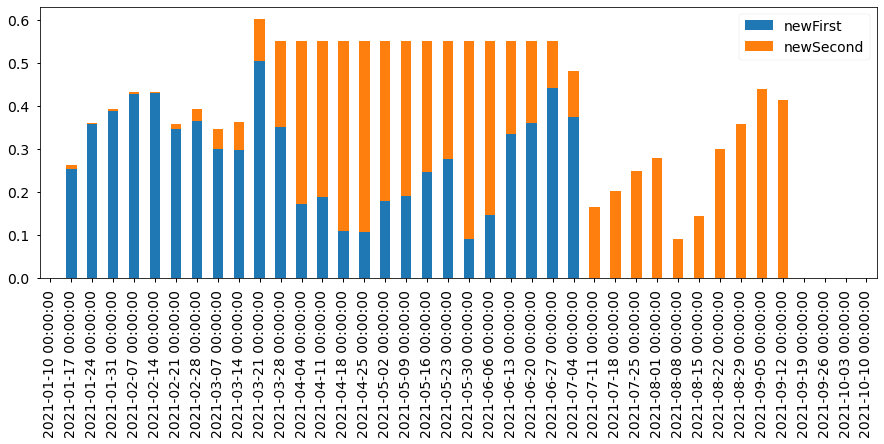

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
d = df.copy(deep=True)
#d.index = d.index.date
d[["newFirst","newSecond"]].resample("W").mean().plot.bar(stacked=True, ax=ax)

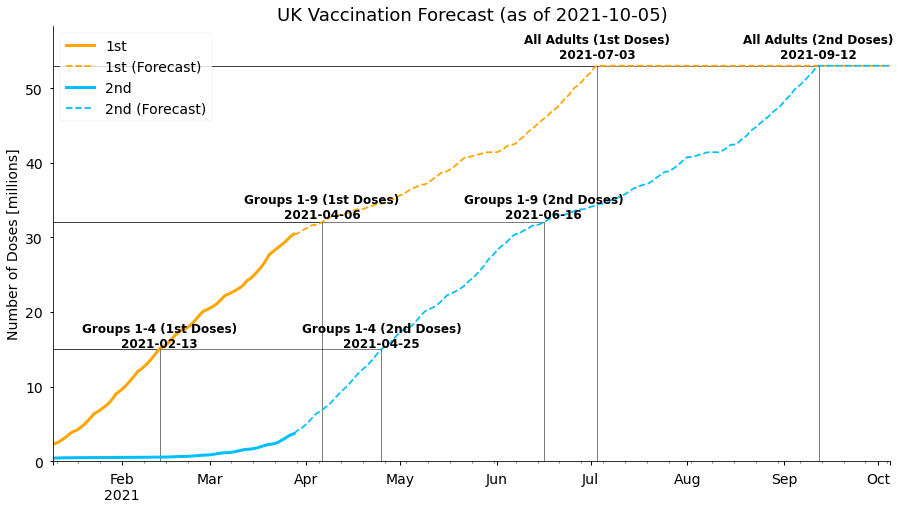

In [27]:
plot_cumulative_doses(
    df, forecast_date=last_data, figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})"
)